# Generating plots for FLASH

In [35]:
# from dsfunctions import forward_pass, forward_pass_nsteps, sample_windspeed, sample_winddirection, sample_geometry
# from dsfunctions import plot_matrix, plot_matrix_ensemble, align_geoms, interpolate_geom, get_observation, plot_geometry
# from dsfunctions import geom_to_vector, reproject_geom, validate_geom
# from dsfuncs_v2 import forward_pass_farsite, generate_landscape


from putils import get_observation, plot_geometry, plot_matrix
from dautils import sample_winddirection, sample_windspeed, validate_geom, adjusted_state_EnKF_farsite, geom_to_state, align_states
from futils import forward_pass_farsite, generate_landscape

import datetime
import uuid

import numpy as np
from matplotlib import pyplot as plt

import contextily as ctx

import pickle
from shapely.geometry import Polygon
from tqdm import tqdm

## Load data

In [2]:
description = 'CA-FKU-FLASH'

# with open(f'./Bridge2021_results_22082024_vsz1_wsz100.pkl', 'rb') as f:
#     data = pickle.load(f)

# with open(f'./Bridge2021_results_22082024_vsz1_wsz1.pkl', 'rb') as f:
#     data = pickle.load(f)

with open(f'/home/tcaglar/farsite-devAPI/data/CA-FKU-FLASH_results_20092024_vsz100_wsz100.pkl', 'rb') as f:
    data = pickle.load(f)

# with open(f'./Bridge2021_results_22082024_vsz100_wsz1.pkl', 'rb') as f:
#     data = pickle.load(f)

# with open(f'./Bridge2021_results_22082024_vsz1000_wsz1.pkl', 'rb') as f:
#     data = pickle.load(f)



adjusted_geom_lst = data['adjusted_geom']
zkphat_ensemble_lst = data['zkphat_ensemble_lst']
xkphat_ensemble_lst = data['xkphat_ensemble_lst']
ykhat_ensemble_lst = data['ykhat_ensemble_lst']

tfin = 5



## Load the observations

In [3]:
# MAria Fire wind values
# Windspeed and Wind direction that were used live
# wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
# wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

# FLASH fire wind values
wslst = [15]*(tfin)
wdlst = [200]*(tfin)
print('Chose CA-FKU-FLASH fire')

# # River fire wind values
# wslst = [15]*(tfin)
# wdlst = [215]*(tfin)

observations = []
timestamps = []
sampled_wslst = []
sampled_wdlst = []

for tix in tqdm(range(tfin)):
    obs, ts = get_observation(description, tix)
    observations.append(obs)
    timestamps.append(ts)

Chose CA-FKU-FLASH fire


100%|██████████| 5/5 [00:53<00:00, 10.67s/it]


## Generate estimated ignition

In [4]:
# Maria ignition
# ignition_timepoint = timestamps[0].replace(hour=18, minute=13)
# x,y = (-2084217.1484733422, 1503560.461310427)
# width = 200
# xshift = 2000
# yshift = 1500

# elif description == 'CA-FKU-FLASH':
ignition_timepoint = timestamps[0].replace(hour=0, minute=0, second=0, microsecond=0)
x,y = observations[0].centroid.x, observations[0].centroid.y
width = 100
xshift = -250
yshift = -350


# # # Bridge2021 ignition
# ignition_timepoint = timestamps[0].replace(hour=12, minute=53)
# x,y = x,y = observations[0].centroid.x, observations[0].centroid.y
# width = 100
# xshift = -50
# yshift = 50

# River2021 ignition
# ignition_timepoint = timestamps[0].replace(hour=14, minute=0)
# x,y = x,y = observations[0].centroid.x, observations[0].centroid.y
# width = 100
# xshift = -1200
# yshift = -2000

x += xshift
y+= yshift
ignition = Polygon([(x-width, y), (x, y), (x,y-width), (x-width, y-width)])

lcppath = generate_landscape(ignition, description=description)

## Plot ignition + perimeters

 20%|██        | 1/5 [00:10<00:41, 10.50s/it]

0 days 00:00:00, 0 days 00:00:01.944000


 40%|████      | 2/5 [00:21<00:31, 10.52s/it]

0 days 00:00:01.944000, 0 days 07:28:00.063000


 60%|██████    | 3/5 [00:31<00:21, 10.53s/it]

0 days 07:28:02.007000, 0 days 11:05:00.124000


 80%|████████  | 4/5 [00:42<00:10, 10.53s/it]

0 days 18:33:02.131000, 0 days 14:10:59.805000


100%|██████████| 5/5 [00:52<00:00, 10.51s/it]

1 days 08:44:01.936000


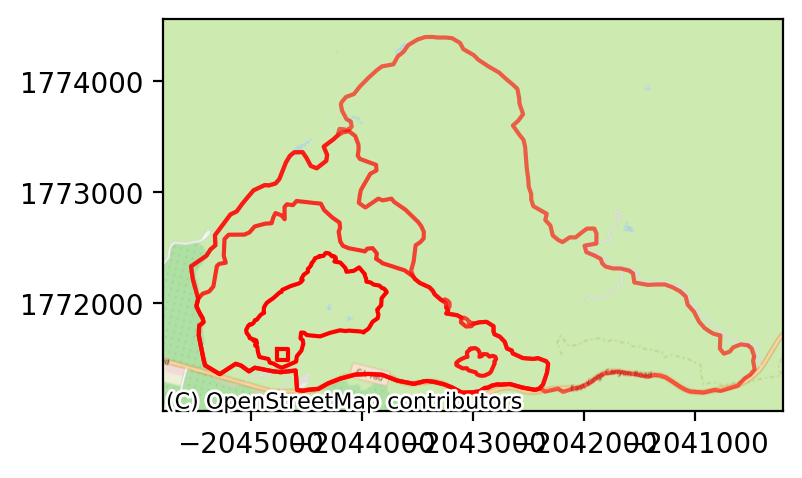

In [7]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(ignition, ax=ax, color='red')

for i in tqdm(range(tfin)):
    geom, timestamp = get_observation(description, i)
    plot_geometry(geom, ax=ax, label=timestamp, color=(1,0,0,1-i/10))

    if i < (tfin-1):
        print(f'{timestamp - timestamps[0]}, {timestamps[i+1]-timestamps[i]}')
    else:
        print(f'{timestamp - timestamps[0]}')

    # break
# # Bridge boundaries
# # Bridge boundaries
# ax.set_ylim((4709010.56092576, 4711600.804956875))
# ax.set_xlim((-13473855.436906476, -13471093.057568321))


# # Maria boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

In [14]:
dt = timestamps[0] - ignition_timepoint

dist_res = int(ignition.exterior.length/n_vertex)
perim_res = dist_res

forward_geom = forward_pass_farsite(ignition, {'windspeed': wslst[0],
                                                     'winddirection': wdlst[0],
                                                     'dt': dt},
                                    lcppath=lcppath, description=description,
                                    dist_res=dist_res, perim_res=perim_res)

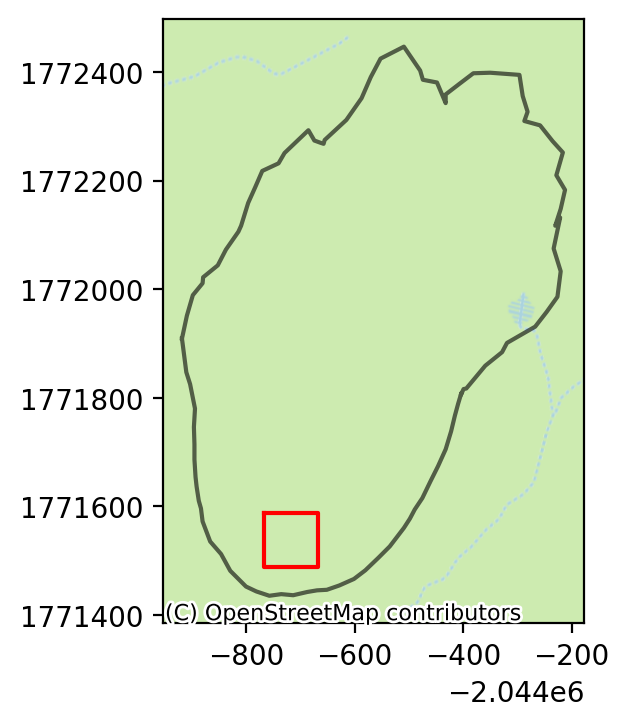

In [16]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(ignition, ax=ax, color='red')
plot_geometry(forward_geom, ax=ax, label=timestamps[0], color=(0,0,0,1-i/10))

# # Bridge boundaries
# ax.set_ylim((4709010.56092576, 4711600.804956875))
# ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

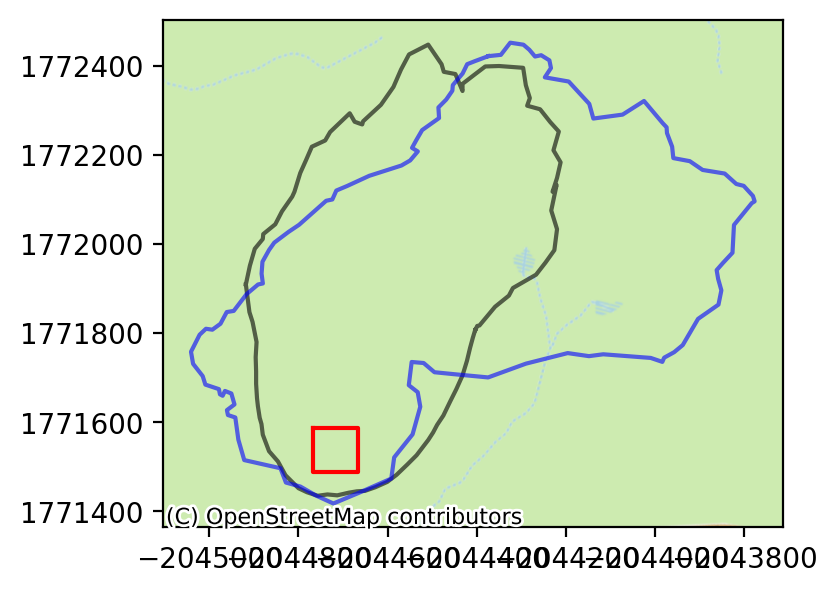

In [17]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(ignition, ax=ax, color='red')
plot_geometry(forward_geom, ax=ax, label=timestamps[0], color=(0,0,0,1-i/10))
plot_geometry(observations[0], ax=ax, label=timestamps[0], color=(0,0,1,1-i/10))


# # Bridge boundaries
# ax.set_ylim((4709010.56092576, 4711600.804956875))
# ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

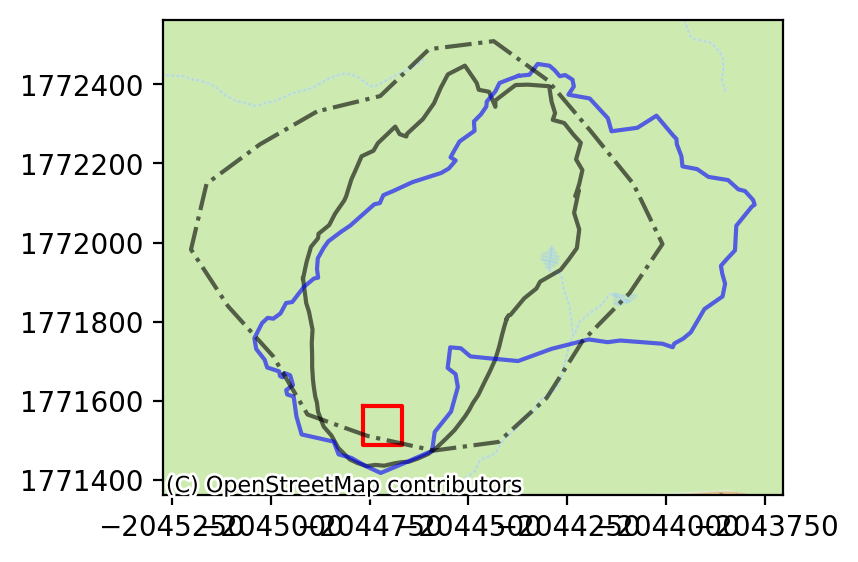

In [18]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(ignition, ax=ax, color='red')
plot_geometry(forward_geom, ax=ax, label=timestamps[0], color=(0,0,0,1-i/10))
plot_geometry(observations[0], ax=ax, label=timestamps[0], color=(0,0,1,1-i/10))
plot_geometry(adjusted_geom_lst[0], ax=ax, label=timestamps[0], color=(0,0,0,1-i/10), ls='-.')


# # Bridge boundaries
# ax.set_ylim((4709010.56092576, 4711600.804956875))
# ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

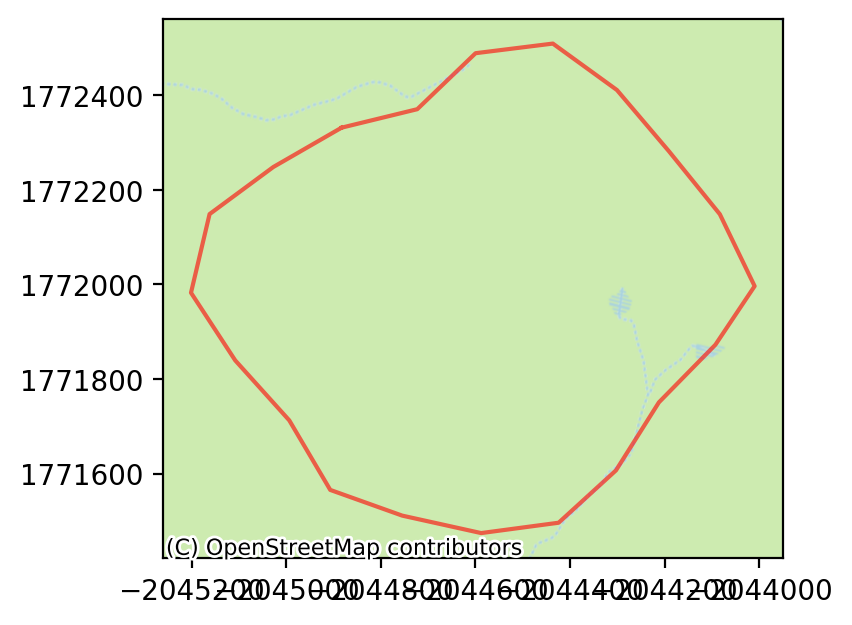

In [19]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(adjusted_geom_lst[0], ax=ax, label=timestamps[0], color=(1,0,0,1-i/10))


# # Bridge boundaries
# ax.set_ylim((4709010.56092576, 4711600.804956875))
# ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

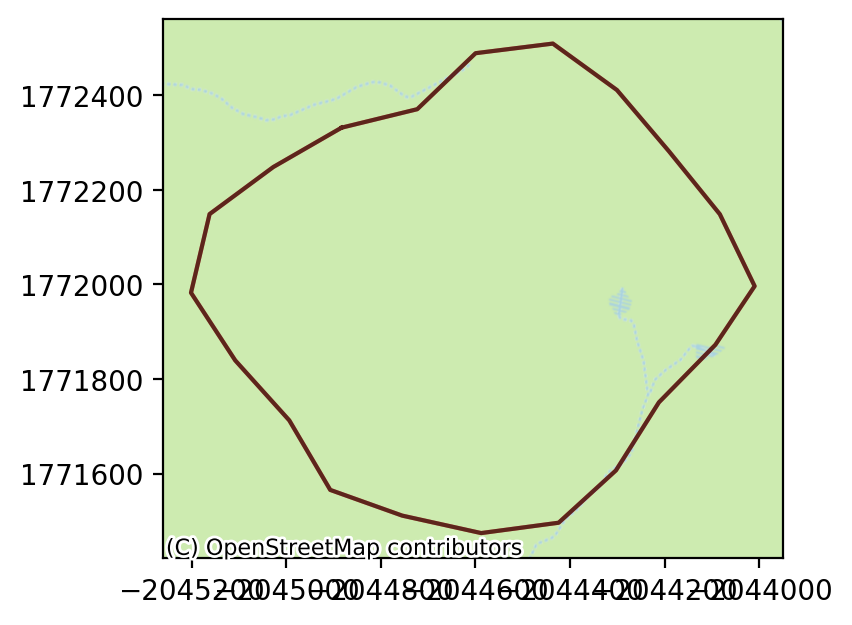

In [21]:
dt = timestamps[1] - timestamps[0]

dist_res = int(adjusted_geom_lst[0].exterior.length/n_vertex)
perim_res = dist_res

forward_geom = forward_pass_farsite(adjusted_geom_lst[0], 
                                     params = {'windspeed': wslst[0],
                                               'winddirection': wdlst[0],
                                               'dt': dt},
                                    lcppath=lcppath, description=description,
                                    dist_res=dist_res, perim_res=perim_res)

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(adjusted_geom_lst[0], ax=ax, label=timestamps[0], color=(1,0,0,1-i/10))
plot_geometry(forward_geom, ax=ax, label=timestamps[0], color=(0,0,0,1-i/10))

# # Bridge boundaries
# ax.set_ylim((4709010.56092576, 4711600.804956875))
# ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

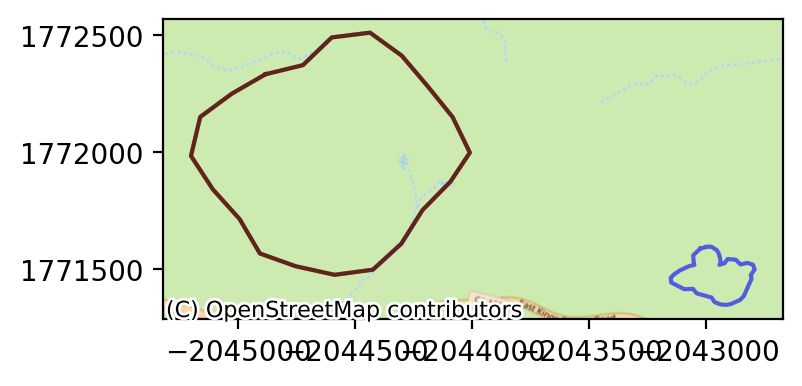

In [22]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(adjusted_geom_lst[0], ax=ax, label=timestamps[0], color=(1,0,0,1-i/10))
plot_geometry(forward_geom, ax=ax, label=timestamps[0], color=(0,0,0,1-i/10))
plot_geometry(observations[1], ax=ax, label=timestamps[0], color=(0,0,1,1-i/10))
# # Bridge boundaries
# ax.set_ylim((4709010.56092576, 4711600.804956875))
# ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

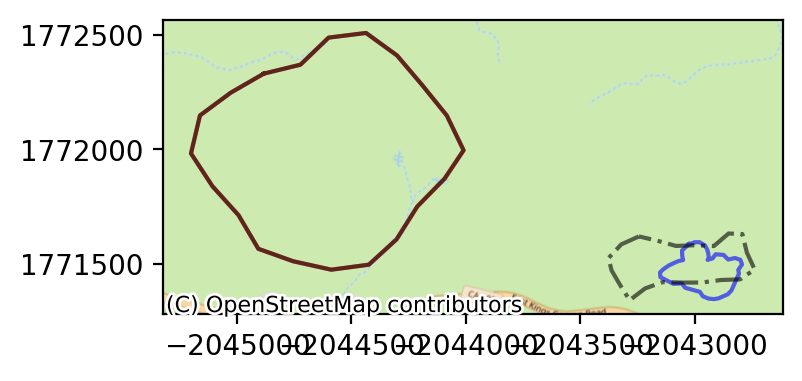

In [23]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(adjusted_geom_lst[0], ax=ax, color=(1,0,0,1-i/10))
plot_geometry(forward_geom, ax=ax, color=(0,0,0,1-i/10))
plot_geometry(observations[1], ax=ax, color=(0,0,1,1-i/10))
plot_geometry(adjusted_geom_lst[1], ax=ax, color=(0,0,0,1-i/10), ls='-.')
# # Bridge boundaries
# ax.set_ylim((4709010.56092576, 4711600.804956875))
# ax.set_xlim((-13473855.436906476, -13471093.057568321))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:5070')

## Calculate error of the farsite solutions after input adjustment

In [28]:
adjusted_outputs = []

all_timestamps = [ignition_timepoint] + timestamps
all_ignitions = [ignition] + adjusted_geom_lst

for i in tqdm(range(len(all_timestamps)-1)):
    ws = wslst[i]
    wd = wdlst[i]
    dt = all_timestamps[i+1] - all_timestamps[i]

    initial = all_ignitions[i]
    dist_res = int(initial.exterior.length/n_vertex)
    perim_res = dist_res
    
    forward_geom = forward_pass_farsite(validate_geom(initial), 
                                     params = {'windspeed': ws,
                                               'winddirection': wd,
                                               'dt': dt},
                                       lcppath=lcppath, description=description,
                                       dist_res=dist_res, perim_res=perim_res)

    adjusted_outputs.append(validate_geom(forward_geom))

100%|██████████| 5/5 [00:20<00:00,  4.08s/it]

buffered polygon is not a polygon..
type = <class 'NoneType'>
buffered polygon is not a polygon..
type = <class 'NoneType'>


In [29]:
def calculate_rms_state(state1, state2):
    return ((state1 - state2)**2).mean()
def calculate_area_diff_state(state1, state2):
    geom1 = Polygon(zip(state1[::2], state1[1::2]))
    geom2 = Polygon(zip(state2[::2], state2[1::2]))
    
    return (geom1.union(geom2) - geom1.intersection(geom2)).area
def align_states(state_lst, vertex_count=None):
    if vertex_count is None:
        vertex_count = max(len(st) for st in state_lst)//2
    x0 = state_lst[0][::2]
    y0 = state_lst[0][1::2]
    x1 = state_lst[1][::2]
    y1 = state_lst[1][1::2]

    geom0 = Polygon(zip(x0,y0))
    geom1 = Polygon(zip(x1,y1))

    geom0, geom1 = align_geoms([geom0, geom1], vertex_count)
    x,y = geom0.exterior.coords.xy
    x0 = x.tolist()[:-1]
    y0 = y.tolist()[:-1]
    state0 = xy_to_state(x0, y0)
    
    x,y = geom1.exterior.coords.xy
    x1 = x.tolist()[:-1]
    y1 = y.tolist()[:-1]
    state1 = xy_to_state(x1, y1)

    return [state0, state1]
    
def xy_to_state(x, y):
    ret = []
    for i in range(len(x)):
        ret.append(x[i])
        ret.append(y[i])

    return np.array(ret).reshape((2*len(x),1))

def state_to_xy(state):
    return state[::2], state[1::2]

def sample_xy(x,y, rng, scale=100):
    xs = rng.normal(x, scale=scale)
    ys = rng.normal(y, scale=scale)

    return xs,ys

## Model output without data assimilation

### Calculate

In [31]:
no_ds_outputs = [ignition]
for tix in tqdm(range(tfin-1)):
    ws = wslst[tix]
    wd = wdlst[tix]
    dt = timestamps[tix+1]-timestamps[tix]
    
    dist_res = int(no_ds_outputs[-1].exterior.length/n_vertex)
    perim_res = dist_res
    
    model_geom = forward_pass_farsite(no_ds_outputs[-1],
                                     params = {'windspeed': ws,
                                               'winddirection': wd,
                                               'dt': dt},
                                     lcppath=lcppath, description=description,
                                     dist_res=dist_res, perim_res=perim_res)
    no_ds_outputs.append(model_geom)
    

 75%|███████▌  | 3/4 [03:56<01:18, 78.87s/it] 


AttributeError: 'NoneType' object has no attribute 'exterior'

In [36]:
adjusted_errors = []
no_adjusted_errors = []
for i in tqdm(range(3)):
    st_adj = geom_to_state(validate_geom(adjusted_geom_lst[i]))
    st_obs = geom_to_state(validate_geom(observations[i]))
    st_noadj = geom_to_state(validate_geom(no_ds_outputs[i]))
    st1, st2 = align_states([st_obs, st_adj], vertex_count=1000)
    adjusted_errors.append(calculate_rms_state(st1, st2))

    st1, st2 = align_states([st_obs, st_noadj], vertex_count=1000)
    no_adjusted_errors.append(calculate_rms_state(st1, st2))

100%|██████████| 3/3 [00:00<00:00,  5.83it/s]


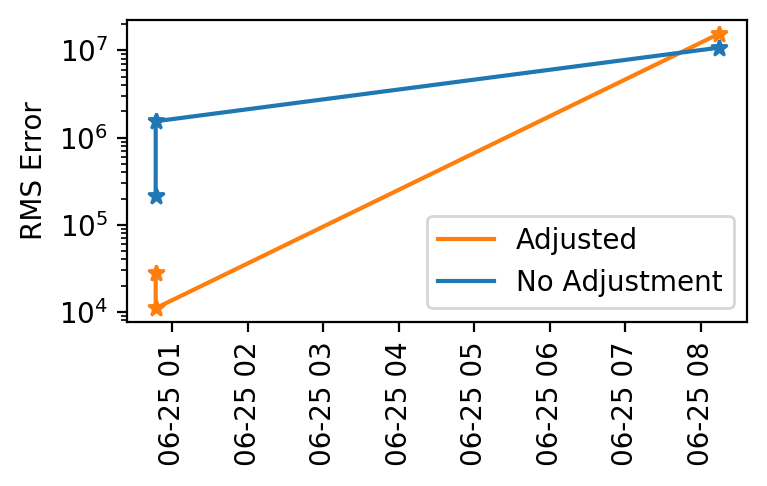

In [39]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
ax.semilogy([ts.to_datetime64() for ts in all_timestamps[1:-2]], adjusted_errors, label='Adjusted', color='tab:orange')
ax.semilogy([ts.to_datetime64() for ts in all_timestamps[1:-2]], adjusted_errors, '*', color='tab:orange')
ax.semilogy([ts.to_datetime64() for ts in all_timestamps[1:-2]], no_adjusted_errors, label='No Adjustment', color='tab:blue')
ax.semilogy([ts.to_datetime64() for ts in all_timestamps[1:-2]], no_adjusted_errors, '*', color='tab:blue')
ax.tick_params(axis='x', labelrotation=90)

ax.set_ylabel('RMS Error')
ax.legend()

## Plot model outputs

Text(0.5, 1, 'No data assimilation output')

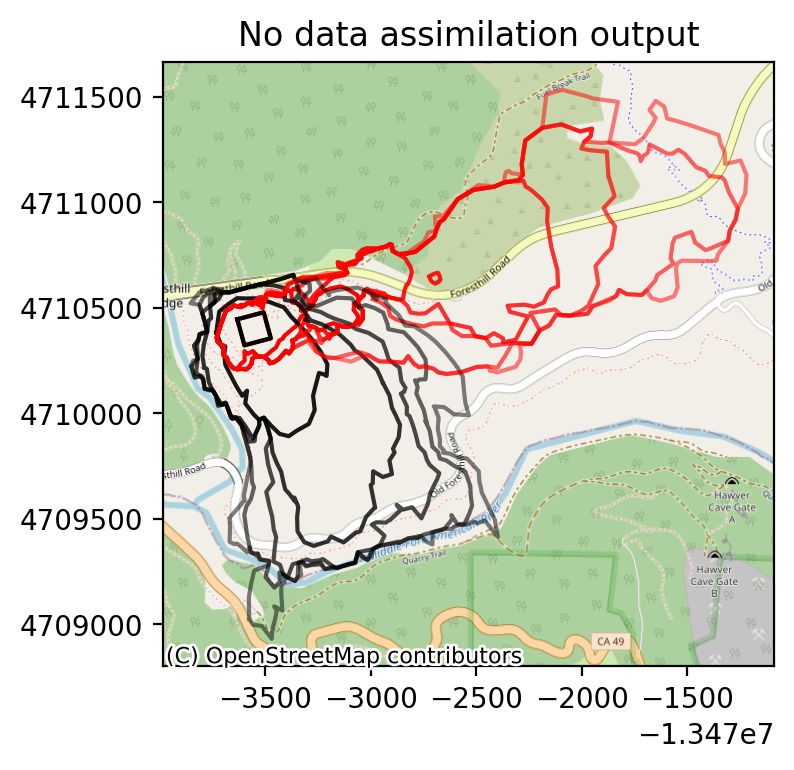

In [21]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(ignition), ax=ax, color='red')
for i in range(tfin):
    model_geom = no_ds_outputs[i]
    plot_geometry(reproject_geom(model_geom), ax=ax, color=(0,0,0,1-i/10))
        
    geom, timestamp = get_observation(description, i)
    plot_geometry(reproject_geom(geom), ax=ax, color=(1,0,0,1-i/10))

    adjusted_geom = adjusted_geom_lst[i]
    # plot_geometry(reproject_geom(adjusted_geom), ax=ax, label=timestamp, color=(0,0,1,1-i/10), ls='--', lw=1)

# Maria boundaries
# ax.set_xlim(-13259480.899793554, -13248356.055776488)
# ax.set_ylim(4066612.9682816155, 4075471.350794237)

# # Bridge boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('No data assimilation output')

Text(0.5, 1.0, 'With data assimilation')

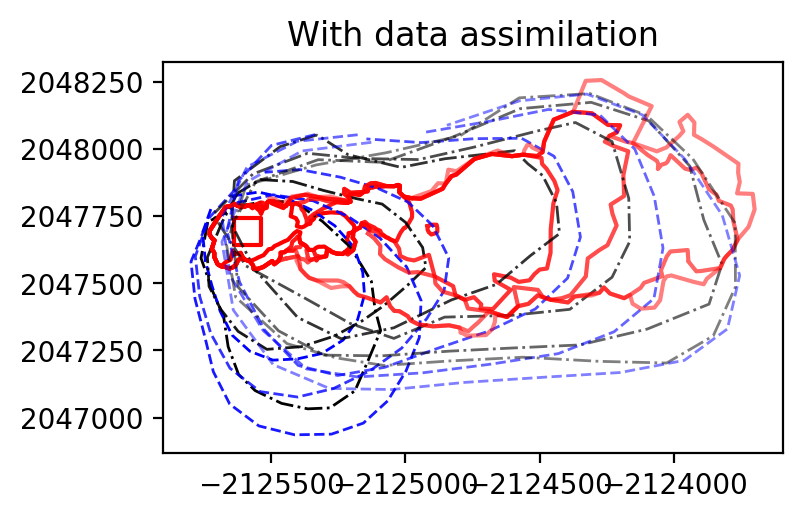

In [22]:
wdlstfig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(ignition, ax=ax, color='red')
for i in range(tfin):
    # model_geom = no_ds_outputs[i]
    # plot_geometry(reproject_geom(model_geom), ax=ax, label=timestamp, color=(0,0,0,1-i/10))
        
    geom, timestamp = get_observation(description, i)
    plot_geometry(geom, ax=ax, label=timestamp, color=(1,0,0,1-i/10))

    adjusted_geom = adjusted_geom_lst[i]
    xkphat_ensemble = xkphat_ensemble_lst[i]
    plot_geometry(adjusted_geom, ax=ax, label=timestamp, color=(0,0,0,1-i/10), ls='-.', lw=1)
    # plot_matrix(xkphat_ensemble, ax=ax, color=(0,0,0,1-i/10), ls='--', lw=1)

    zkphat_ensemble = zkphat_ensemble_lst[i]
    plot_matrix(zkphat_ensemble, ax=ax, color=(0,0,1,1-i/10), ls='--', lw=1)
# Maria boundaries
# ax.set_xlim(-13259480.899793554, -13248356.055776488)
# ax.set_ylim(4066612.9682816155, 4075471.350794237)

# # Bridge boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('With data assimilation')